
Thinking about what we talked about over lunch, I think the most telling
coordinate system for the given set of crystal structures, would be the
one that gives most weight to the differences in  the structures.

The analysis itself shouldn't even be so hard as I first thought. If we
take RMSD as measure of structural difference, then one could proceed as
follows:

* calculate RMSDs between all pairs of structures (after fitting, gmx rms -fit can do that, or any better python package)

* of the two structures with maximal RMSD substract the atom coordinates from one another and normalize this vector - this is already the first "principal component"

* now remove this vector component dimension from the data by something similar in spirit to the Gram-Schmidt-Orthonormalization procedure: $x_{\mathrm{new}} = x-pc1*proj(x,pc1) = x-pc1*x.pc1$

* Repeat from 1 for the $x_{\mathrm{new}}$ to obtain the second component. Because of 3. this should be automatically orthogonal to pc1, but better check.

* End if you have enough or all RMSDs are 0


mdtraj can read xtc files in python, maybe this would be the fastest
shot for putting the pieces together.


## Imports

In [4]:
import os
import re
import matplotlib
import pandas as pd
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.align import rms_fit_trj
from MDAnalysis.analysis.align import rms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

## Plotting settings

In [5]:
sns.set_style("white")
sns.set_context("poster")

## Setting file directories and names

In [6]:
structureDirectory = "./"
alignedTrajectoryFilename = "aligned.xtc"
pdbfiles= [ structureDirectory + file for file in os.listdir(structureDirectory) if file.endswith("mer.pdb")]

## Preparing the trajectory

In [7]:
pdbEnsemble = mda.Universe(pdbfiles[0],pdbfiles)
pdbReferences = mda.Universe(pdbfiles[0],pdbfiles)
with mda.Writer("ensemble.xtc", pdbEnsemble.trajectory.n_atoms) as W:
    for ts in pdbEnsemble.trajectory:
        W.write(pdbEnsemble)
pdbEnsemble = mda.Universe(pdbfiles[0],"ensemble.xtc")


/nethome/snow/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/base.py:733: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")
/nethome/snow/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/XDR.py:126: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "
/nethome/snow/anaconda2/lib/python2.7/site-packages/MDAnalysis/lib/mdamath.py:144: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))


In [8]:
ensembleRMSDs=[]

# find best reference structure that minimises the rmsd sum after fitting
for referenceFrame in pdbReferences.trajectory:
    tmp = []
    for mobileFrame in pdbEnsemble.trajectory:
        tmp.append(rms.rmsd(mobileFrame,referenceFrame,superposition=True)) 
    ensembleRMSDs.append(tmp)

In [9]:
bestReference = np.argmin(sum(np.array(ensembleRMSDs)))

In [10]:
reference = mda.Universe(pdbfiles[bestReference])
reference.atoms.positions-=reference.atoms.center_of_geometry()
rmsds = rms_fit_trj(pdbEnsemble, reference, filename=alignedTrajectoryFilename)

Fitted frame    46/46  [100.0%]


In [11]:
plt.figure(figsize=(15,7.5))
sortedIndices = np.argsort(rmsds.rms)
plt.plot(rmsds.rmsd[sortedIndices],'.',ms=20)
plt.ylim(bottom=0)
plt.xticks([])
plt.ylabel("RMSD from Reference Structure [Å]")
plt.grid()
for i,y in enumerate(rmsds.rmsd[sortedIndices]):
    plt.text(i-0.25,y-0.15,pdbEnsemble.trajectory.filenames[i][15:19],rotation=90)
sns.despine(offset=20, bottom=True, left = True)
plt.show()
plt.close()

AttributeError: 'str' object has no attribute 'rms'

## The maxDifference algorithm

### defining essential functions

In [12]:
def pairRmsd(traj):
    return np.array([[rms.rmsd(frameA,frameB) for frameA in traj] for frameB in traj])

def findMaxDifferenceVector(traj):
    pR = pairRmsd(traj)
    furthestApart = np.unravel_index(pR.argmax(), pR.shape)
    extremeCoordinates = [traj[frameIndex] for frameIndex in furthestApart]
    differenceVector = np.diff(extremeCoordinates, axis=0)[0].ravel()
    norm2 = np.inner(differenceVector, differenceVector)
    return pR,differenceVector/np.sqrt(norm2)

def removeComponent(traj,x):
    for frame in traj:
        frame -= x.reshape(-1,3) * np.inner(frame.ravel(),x)


### reading in pre-prepared trajectory from above

In [13]:
alignedPDBs = mda.Universe(pdbfiles[0],alignedTrajectoryFilename)
traj=[frame.positions.copy() for frame in alignedPDBs.trajectory]

### Calculating the maximmaly different modes

In [14]:
pairwiseRMSDtraj=[]
pcs=[]
for _ in range(len(traj)-1):
    
    pairwiseRMSDs,x = findMaxDifferenceVector(traj)
    removeComponent(traj,x)

    pcs.append(x)
    pairwiseRMSDtraj.append(pairwiseRMSDs)

### Plotting results and consistency checks

In [15]:
sns.set_style('ticks')

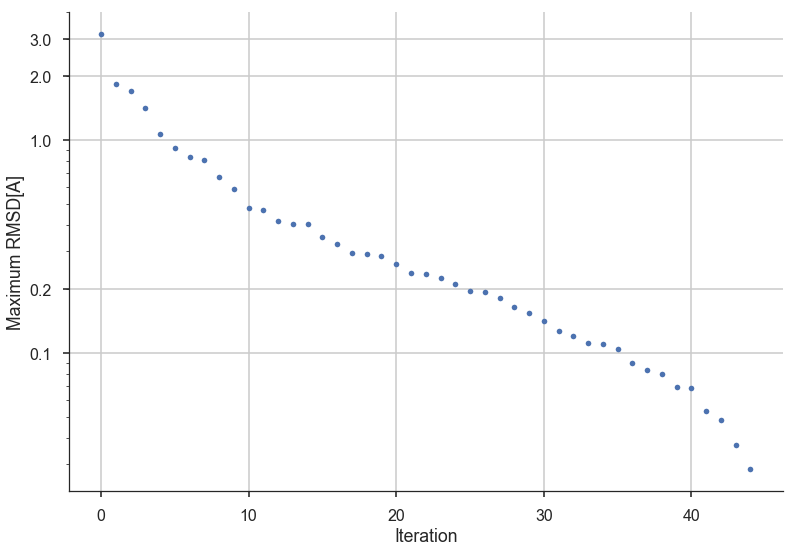

In [16]:
maxRMSDdist = [np.max(rmsd) for rmsd in pairwiseRMSDtraj]
fig,ax = plt.subplots()
ax.plot(maxRMSDdist,'.')
ax.set_yscale("log")
ax.set_yticks([0.1,0.2,1,2,3])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Maximum RMSD[A]')
plt.xlabel('Iteration')
sns.despine()
plt.grid()
plt.show()
plt.close()

#### plot clusterd rmsds per step

In [17]:
import scipy.cluster.hierarchy as sch
Y = sch.linkage(pairwiseRMSDtraj[0], method='centroid')
Z = sch.dendrogram(Y, orientation='right',no_plot=True)
clusteredIndex=Z['leaves']

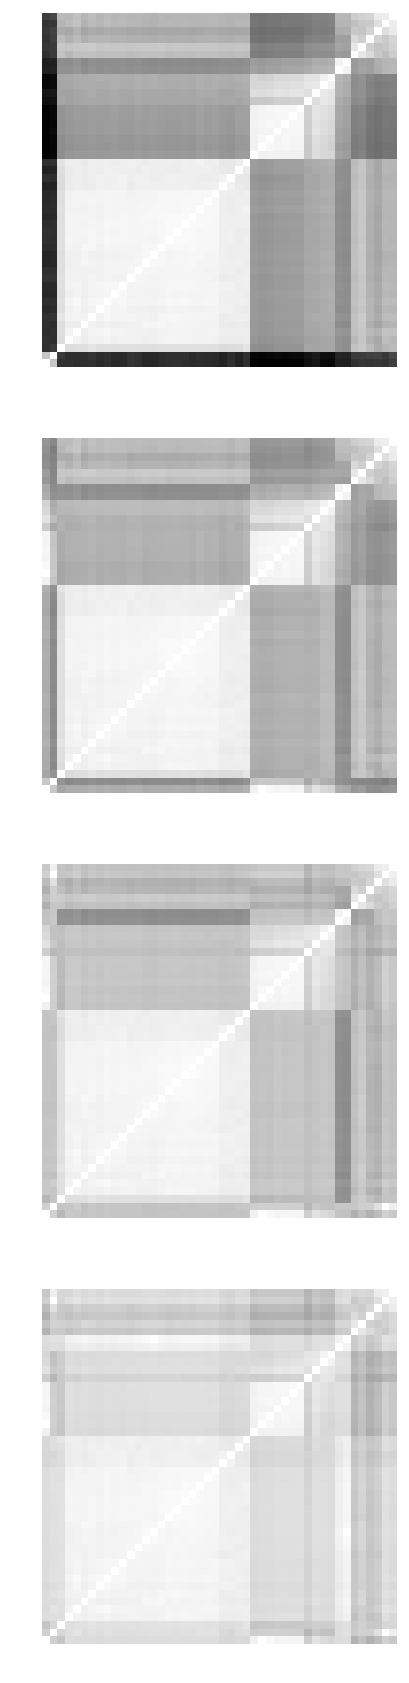

In [18]:
maxpairRMSD=np.max(pairwiseRMSDtraj)
fig, axes = plt.subplots(4,1,figsize=(7,30))
for ax,rmsd in zip(axes,pairwiseRMSDtraj):
    D = rmsd[clusteredIndex,:]
    D = D[:,clusteredIndex]
    ax.imshow(D,origin='lower',vmin=0, vmax=maxpairRMSD)
    ax.axis('off')
plt.show()
plt.close()

### Project onto components

In [19]:
originalTraj=[frame.positions.copy() for frame in alignedPDBs.trajectory]

In [20]:
projections=np.array([[np.inner(frame.ravel(),pc) for frame in originalTraj] for pc in pcs])

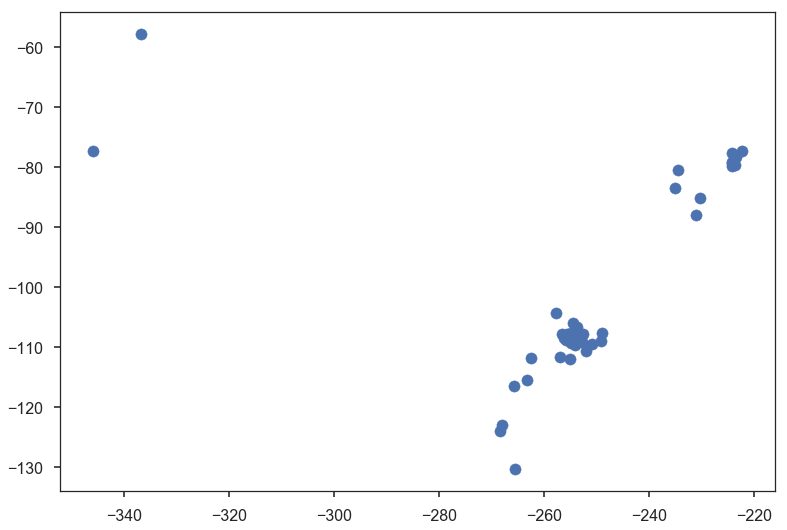

In [21]:
plt.scatter(projections[0],projections[1])
plt.show()
plt.close()

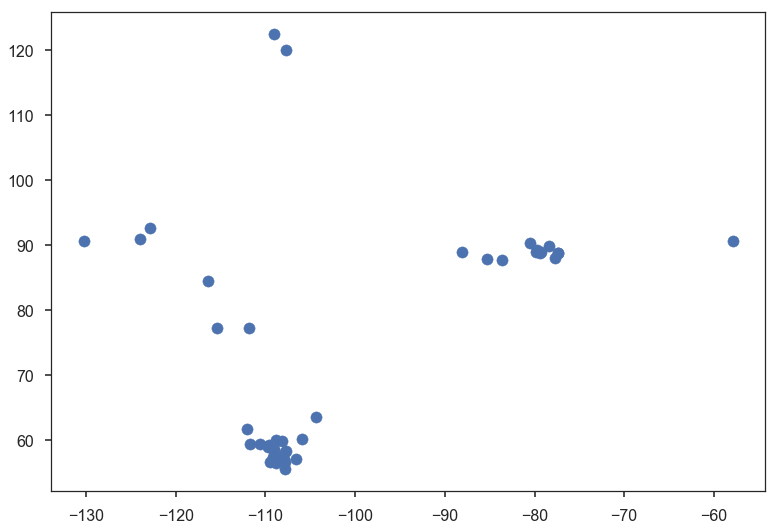

In [22]:
plt.scatter(projections[1],projections[2])
plt.show()
plt.close()

In [23]:
def getProjection(trajectoryFileName):
    fittedTrajFileName = 'tmp.xtc'
    simulationTraj = mda.Universe(pdbfiles[0],trajectoryFileName)
    rmsds = rms_fit_trj(simulationTraj,reference, filename=fittedTrajFileName)
    fittedTrajectory = mda.Universe(pdbfiles[0],fittedTrajFileName)
    return np.array([[np.inner(frame.positions.ravel(),pc) for frame in fittedTrajectory.trajectory] for pc in pcs])

In [24]:
projectionsF238L = getProjection('F238L_1/4NPQ_F238L_pH46_md1.xtc')

Fitted frame  1261/1261  [100.0%]


In [25]:
projectionsI9T = getProjection('/nethome/snow/Laura_GLIC_pca/I9T_1/4NPQ_I9T_pH46_md1.xtc')
projections4HFI = getProjection('/nethome/snow/Laura_GLIC_pca/4HFI_pH70/4HFI_WT_pH70_md1_ca.xtc')
projections4HFI46 = getProjection('/nethome/snow/Laura_GLIC_pca/4HFI_pH46/4HFI_WT_pH46_md1.xtc')
projectionsF238L = getProjection('F238L_1/4NPQ_F238L_pH46_md1.xtc')
projectionsBA2 = getProjection('BA2_pH46/4NPQ_BA2_pH46_md1.xtc')
projectionsI9T_2 = getProjection('I9T_2/4NPQ_I9T_pH46_md2.xtc')
projectionsWT46 = getProjection('WT_pH46/4NPQ_WT_pH46_md1.xtc')

Fitted frame  1595/1595  [100.0%]
Fitted frame  1001/1001  [100.0%]
Fitted frame   553/553  [100.0%]
Fitted frame  1261/1261  [100.0%]
Fitted frame  1006/1006  [100.0%]
Fitted frame   910/910  [100.0%]
Fitted frame   581/581  [100.0%]


In [26]:
projectionsdubmut = getProjection('dub_mut_1/4NPQ_233_238_mut_pH46_md1.xtc')

Fitted frame   312/312  [100.0%]


In [27]:
arrayevec = []
for x in range(10):
    evec = pd.read_table('WT_pH46/x0'+str(x),skiprows=2 ,delim_whitespace=True,header=None)
    arrayevec.append(np.array(evec).ravel())

In [28]:
productMatrix = np.array([np.dot(arrayevec[i],pcs[j]) for i in range(10) for j in range(10)])

In [29]:
productMatrix

array([-0.32648095, -0.13392753, -0.06668013,  0.00898138,  0.07383147,
        0.00209883,  0.09625344,  0.00461163,  0.06002955,  0.02320925,
       -0.14939901,  0.05487465,  0.20911782, -0.09475839,  0.03026982,
       -0.02384201, -0.07718252,  0.15001681,  0.03575184, -0.12805781,
       -0.06139593,  0.09984862, -0.18109131, -0.20489166, -0.02979819,
        0.04711144, -0.03658375,  0.09417473,  0.03985431, -0.00780801,
        0.20174384,  0.05281122, -0.09867593,  0.24362759,  0.11453485,
       -0.07115062, -0.11511237,  0.02297736,  0.06947165, -0.13898394,
       -0.05755537,  0.11845658, -0.0038576 ,  0.0121834 ,  0.2828037 ,
        0.04952787,  0.00263074,  0.10076942, -0.04110468, -0.0485292 ,
       -0.08805738, -0.04998149,  0.05878608, -0.10754899, -0.06655657,
        0.28043436,  0.00131855, -0.09205267, -0.07638611,  0.02026679,
        0.007936  ,  0.12764709,  0.01378587,  0.09620926, -0.11248482,
       -0.114542  ,  0.02981755,  0.04947638, -0.06149365, -0.12

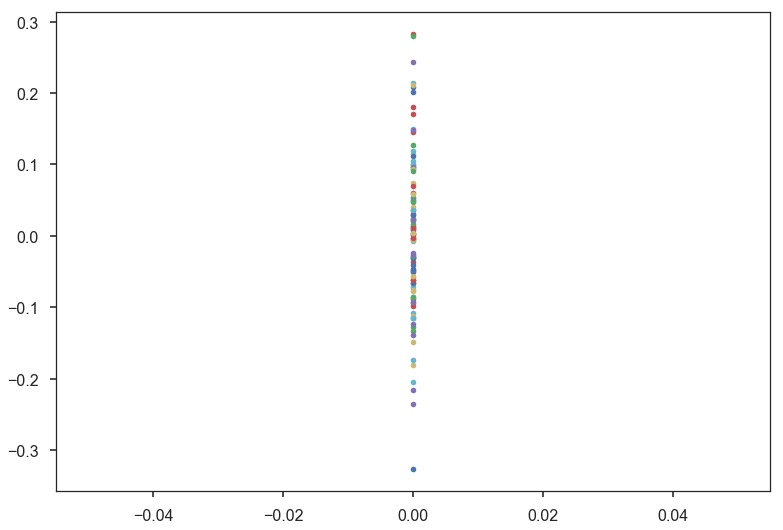

In [30]:
plt.figure()
for pm in productMatrix:
    plt.plot(pm,'.')
plt.show()

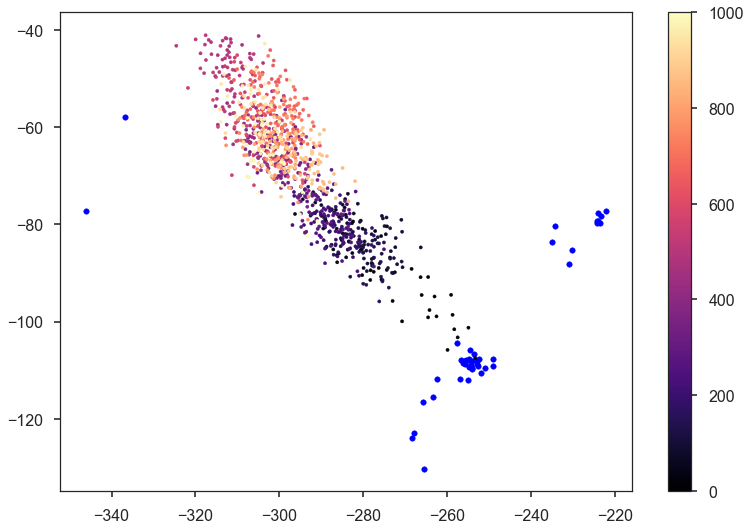

In [45]:
pcIndex1=0
pcIndex2=1
plt.scatter(projections[pcIndex1],projections[pcIndex2],s=30,c='b')
#I9T = plt.scatter(projectionsI9T[pcIndex1],projectionsI9T[pcIndex2], s=10,c=np.arange(len(projectionsI9T.T)), cmap='magma')
HFI7 = plt.scatter(projections4HFI[pcIndex1],projections4HFI[pcIndex2], s=10, c=np.arange(len(projections4HFI.T)),cmap='magma')
#HFI4 = plt.scatter(projections4HFI46[pcIndex1],projections4HFI46[pcIndex2], s=10,c=np.arange(len(projections4HFI46.T)),cmap='viridis')
#F238L = plt.scatter(projectionsF238L[pcIndex1],projectionsF238L[pcIndex2], s=10,c=np.arange(len(projectionsF238L.T)), cmap='viridis')
#BA2 = plt.scatter(projectionsBA2[pcIndex1],projectionsBA2[pcIndex2], s=10,c=np.arange(len(projectionsBA2.T)),cmap='plasma')
#I9T_2 = plt.scatter(projectionsI9T_2[pcIndex1],projectionsI9T_2[pcIndex2], s=10, c=np.arange(len(projectionsI9T_2.T)),cmap='viridis')
#WT46 = plt.scatter(projectionsWT46[pcIndex1],projectionsWT46[pcIndex2],s=10,c=np.arange(len(projectionsWT46.T)),cmap='viridis')
#dubmut = plt.scatter(projectionsdubmut[pcIndex1],projectionsdubmut[pcIndex2],s=10,c=np.arange(len(projectionsdubmut.T)),cmap='plasma')
plt.colorbar(HFI7)
plt.show()
plt.close()